In [24]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
experiments = ["170524_NB501938_0004_AHM5K3BGX2",
"170525_NB501938_0005_AHM7HYBGX2",
"170525_NB501961_0004_AHMHKHBGX2",
"170526_NB501961_0005_AHM7KNBGX2",
"170527_NB501961_0006_AHMJKFBGX2",
#"170624_NB501938_0007_AHMJFVBGX2",
"170624_NS500126_0711_AHM3MGBGX2",
"170625_NB501938_0008_AHCT5TBGX2",
"170625_NS500126_0712_AHYFKGBGXY",
"170626_NB501938_0009_AHW527BGXY"]

In [ ]:
for exp in experiments:
    outdir = "data/" + exp
    #os.system("mkdir " + outdir)
    os.system("python /Users/josh/src/cloud-rnaseq/geo_meta/generate_gene_cell_table.py"
           " -s s3://biohub-spyros/data "
           " -d " + exp + ""
           " -f " + outdir + ".gct.csv "
           " -l " + outdir + ".starlog.csv "
           " -m " + exp + ".mapping.csv")

In [3]:
frames = []
for fname in glob.glob('data/*.gct.csv'):
    df = pd.read_csv(fname,index_col=0, header = 3)
    frames.append(df.T)
    print "reading " + fname
gct_raw = pd.concat(frames)

reading data/170524_NB501938_0004_AHM5K3BGX2.gct.csv
reading data/170525_NB501938_0005_AHM7HYBGX2.gct.csv
reading data/170525_NB501961_0004_AHMHKHBGX2.gct.csv
reading data/170526_NB501961_0005_AHM7KNBGX2.gct.csv
reading data/170527_NB501961_0006_AHMJKFBGX2.gct.csv
reading data/170624_NS500126_0711_AHM3MGBGX2.gct.csv
reading data/170625_NB501938_0008_AHCT5TBGX2.gct.csv
reading data/170626_NB501938_0009_AHW527BGXY.gct.csv


In [4]:
ercc_cols = [col for col in gct_raw.columns if 'ERCC-' in col]
htseq_meta_cols = [col for col in gct_raw.columns if '__' in col]
gene_cols = [col for col in gct_raw.columns if not ('ERCC-' in col or '__' in col)]

In [5]:
gct = gct_raw[gene_cols]
gct = gct.drop(['Rn45s'],axis=1)
#empties = [row for row in gct.index if 'empty' in row]
#gct = gct.drop(empties)

In [6]:
frames = []
for fname in glob.glob('data/*.starlog.csv'):
    df = pd.read_csv(fname,index_col=0, header = 3)
    frames.append(df.T)
    print "reading " + fname
starlogs_raw = pd.concat(frames)

reading data/170524_NB501938_0004_AHM5K3BGX2.starlog.csv
reading data/170525_NB501938_0005_AHM7HYBGX2.starlog.csv
reading data/170525_NB501961_0004_AHMHKHBGX2.starlog.csv
reading data/170526_NB501961_0005_AHM7KNBGX2.starlog.csv
reading data/170527_NB501961_0006_AHMJKFBGX2.starlog.csv
reading data/170624_NS500126_0711_AHM3MGBGX2.starlog.csv
reading data/170625_NB501938_0008_AHCT5TBGX2.starlog.csv
reading data/170626_NB501938_0009_AHW527BGXY.starlog.csv


In [7]:
#starlogs = starlogs.drop(empties)

In [9]:
starlogs = starlogs_raw.applymap(lambda x: x.strip().strip('%') if isinstance(x, str) else x)
starlogs = starlogs.apply(pd.to_numeric, errors='ignore')

In [11]:
starlogs['plate'] = starlogs.index.map(lambda x: x.split('-')[1])

In [12]:
plate_meta = pd.read_csv('data/MACA_Metadata_384.csv',index_col=0)

In [13]:
meta = starlogs.join(plate_meta, on='plate')
meta['id'] = meta['Mouse ID (age_#_sex)']
meta['age'] = meta['id'].map(lambda x: int(x.split('_')[0]))
meta['tissue_subtissue'] = meta['tissue'] + ': ' + meta['subtissue'].astype(str)

In [22]:
def paolo_out(gct, meta):
    with open('/Users/josh/src/maca/data/paolo/ExpressionMatrix.csv','w') as f:
        outstr = 'Gene' + gct.T.to_csv()
        f.write(outstr)
        f.close()

    with open('/Users/josh/src/maca/data/paolo/MetaData.csv','w') as f:
        outstr = 'Cell' + meta.loc[gct.index,:].to_csv()
        f.write(outstr)
        f.close()

In [23]:
paolo_out(gct, meta)

# QC

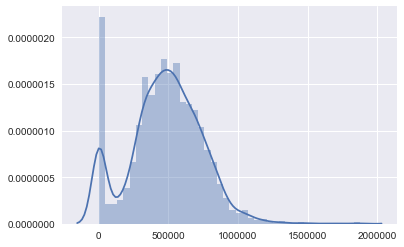

In [26]:
sns.distplot(gct.T.sum())

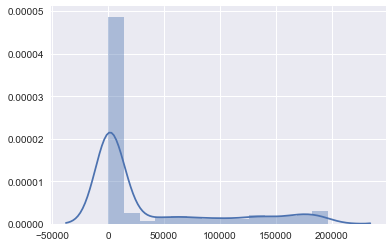

In [29]:
sns.distplot(gct.T.sum()[gct.T.sum()<2e5])

In [30]:
# < 50k reads is a reasonable cutoff

In [31]:
# is the fraction of cells with < 50k reads the same across tissues?

In [44]:
from IPython.display import display
with pd.option_context("display.max_columns",30):
    display(meta.groupby(['tissue_subtissue','age']).mean())

Mapping speed, Million of reads per hour  \
tissue_subtissue    age                                             
brain: brain stem   24                                 156.851228   
brain: cortex       24                                 166.814036   
                    30                                 157.179383   
brain: hippocampus  24                                 180.994194   
brain: striatum     30                                 149.193214   
fat: GAT            24                                 172.199563   
heart: LV           24                                 152.231268   
heart: RV           30                                 132.126069   
mammary gland: nan  24                                 163.938120   
pancreas: endocrine 30                                 199.574918   
pancreas: nan       24                                 141.930613   

                         Number of input reads  Average input read length  \
tissue_subtissue    age                                                     
brain: brain stem   24            8.034650e+05                      150.0   
brain: cortex       24            9.472134e+05                      150.0   
                    30            9.960941e+05                      150.0   
brain: hippocampus  24            1.125652e+06                      150.0   
brain: striatum     30            1.027439e+06                      150.0   
fat: GAT            24            1.021914e+06                      150.0   
heart: LV           24            8.415697e+05                      150.0   
heart: RV           30            8.589839e+05                      150.0   
mammary gland: nan  24            9.216676e+05                      150.0   
pancreas: endocrine 30            1.578223e+06                      150.0   
pancreas: nan       24            7.168184e+05                      150.0   

                         Uniquely mapped reads number  \
tissue_subtissue    age                                 
brain: brain stem   24                   7.032658e+05   
brain: cortex       24                   8.200519e+05   
                    30                   8.541545e+05   
brain: hippocampus  24                   9.799928e+05   
brain: striatum     30                   9.038294e+05   
fat: GAT            24                   8.896019e+05   
heart: LV           24                   5.750890e+05   
heart: RV           30                   6.834243e+05   
mammary gland: nan  24                   8.022396e+05   
pancreas: endocrine 30                   1.294772e+06   
pancreas: nan       24                   6.121126e+05   

                         Uniquely mapped reads %  Average mapped length  \
tissue_subtissue    age                                                   
brain: brain stem   24                 87.291111             148.613596   
brain: cortex       24                 85.990036             148.567782   
                    30                 85.734115             148.447366   
brain: hippocampus  24                 84.013226             148.514086   
brain: striatum     30                 87.156853             148.352121   
fat: GAT            24                 85.938594             148.297000   
heart: LV           24                 64.583451             148.538879   
heart: RV           30                 75.611103             148.012207   
mammary gland: nan  24                 86.680085             148.489430   
pancreas: endocrine 30                 81.378689             147.319672   
pancreas: nan       24                 84.342871             147.195323   

                         Number of splices: Total  \
tissue_subtissue    age                             
brain: brain stem   24              283465.233918   
brain: cortex       24              310881.305455   
                    30              322927.415638   
brain: hippocampus  24              364594.731183   
brain: striatum     30              309451.709821   
fat: GAT            24              